Current and Historical Lists of S&P 500 components since 1996: https://github.com/fja05680/sp500/tree/master

Frequency of entry triggers: how many assets trigger the entry rule for a given point in time? This number will be important when we choose the maximum number of positions to hold at any given time.

# Import libraries

In [ ]:
from skfolio import PerfMeasure, RatioMeasure, RiskMeasure, Population
# To easily compare multiple portfolios, we can use the Population class.
from skfolio.optimization import (
    MeanRisk,
    ObjectiveFunction,
    EqualWeighted,
    HierarchicalRiskParity,
)
from skfolio.preprocessing import prices_to_returns
from skfolio.cluster import HierarchicalClustering, LinkageMethod
from skfolio.distance import KendallDistance, MutualInformation
from sklearn.model_selection import train_test_split

In [ ]:
returns = prices_to_returns(prices)
X_train, X_test = train_test_split(returns,train_size=0.7,shuffle=False)

hrp_model = HierarchicalRiskParity(
    risk_measure=RiskMeasure.VARIANCE, 
    hierarchical_clustering_estimator=HierarchicalClustering(
        linkage_method=LinkageMethod.SINGLE,
    ),
    portfolio_params=dict(name="HRP-variance")
)
hrp_model.fit(X_train)
hrp_test = hrp_model.predict(X_test)

eq_w_model = EqualWeighted(
    portfolio_params=dict(name="Equally weighted"),
)
eq_w_model.fit(X_train)
eq_w_test = eq_w_model.predict(X_test)

hrp_model.hierarchical_clustering_estimator_.plot_dendrogram(heatmap=True)
hrp_test.plot_contribution(measure=RiskMeasure.VARIANCE)

population_test = Population([eq_w_test, hrp_test])
population_test.plot_composition()
population_test.plot_cumulative_returns()

summary = population_test.summary()
summary.loc["Annualized Sharpe Ratio"].sort_values()

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick

In [3]:
data = pd.read_csv("Daily_EUSTOXX_DOW.csv", index_col=["Date","Ticker"],parse_dates=['Date'])
stock_data = data.unstack()
stock_data.columns.names = ["Features","Tickers"]

In [5]:
one_year = stock_data.index[0] + pd.DateOffset(months=12) 
print(f'Our data starts from {str(stock_data.index[0])} however we need at least data from 1 \
previous year to optimize the portfolio allocation.', f'We\'ll start \
investing after {one_year}.', sep='\n')

Our data starts from 2010-08-02 00:00:00 however we need at least data from 1 previous year to optimize the portfolio allocation.
We'll start investing after 2011-08-02 00:00:00.


# Portfolio Optimization to get the weights for each month

In [6]:
from pypfopt.efficient_frontier import EfficientFrontier, EfficientSemivariance, EfficientCVaR
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import seaborn as sns

In [1]:
stocks_adj_close = pd.DataFrame(stock_data['Adj_Close'].unstack(level = 1))
# Calculate the daily log returns of the investment universe to use it for the optimization and weights calculation
stocks_return = pd.DataFrame(stock_data['Adj_Close'].groupby(level=1,group_keys=False).apply(lambda x:np.log(x).diff())) \
                .dropna().unstack(level=1)
stocks_return.columns = stocks_return.columns.droplevel(0) # remove Adj_Close level 0 column index

NameError: name 'pd' is not defined

In [ ]:
portfolio_val = 50000

### Risk Management and Constraints

In [ ]:
# Sector constraints
sector_mapper = {
    "MSFT": "Tech",
    "AMZN": "Consumer Discretionary",
    "KO": "Consumer Staples",
    "MA": "Financial Services",
    "COST": "Consumer Staples",
    "LUV": "Aerospace",
    "XOM": "Energy",
    "PFE": "Healthcare",
    "JPM": "Financial Services",
    "UNH": "Healthcare",
    "ACN": "Misc",
    "DIS": "Media",
    "GILD": "Healthcare",
    "F": "Auto",
    "TSLA": "Auto"
}

sector_lower = {
    "Consumer Staples": 0.1, # at least 10% to staples
    "Tech": 0.05 # at least 5% to tech
    # For all other sectors, it will be assumed there is no lower bound
}

sector_upper = {
    "Tech": 0.2,
    "Aerospace":0.1,
    "Energy": 0.1,
    "Auto":0.15
}


ef = EfficientFrontier(mu_hist, S)
tsla_index = ef.tickers.index("TSLA")
ef.add_constraint(lambda w: w[tsla_index] <= 0.05)

ef.add_constraint(lambda w: w[10] >= 0.05)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

# Objective = Original Objective + γ * ∑i=1->n wi^2
# It penalizes large weights in the portfolio to encourage diversification and reduce overfitting to historical data.
ef.add_objective(objective_functions.L2_reg, gamma=1)  # gamma is the tuning parameter


# Position constraints
ef.add_constraint(lambda w: w[0] <= 0.15)  # Max 15% in first asset
ef.add_constraint(lambda w: w[2] >= 0.05)  # Min 5% in third asset

Loop over each month start, select the stocks for the month and calculate their weights.

If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

Calculated each day portfolio return.

In [ ]:
def portfolio_optimization(prices, portfolio_val, optimization_end_date, lower_bound=0 ):
    # Calculate the exponentially-weighted mean of (daily) historical returns, giving higher weight to more recent data, 
    # an improvement over the mean historical return.
    
    # Calculate the mean historical returns.
    mu = expected_returns.mean_historical_return(prices=prices.iloc[:-1], # remove the first day of the investment month (rebalancing)
                                                 compounding=True, 
                                                 log_returns=True,
                                                 frequency=252) # need data of at least a year before
    
    # Estimate the exponentially-weighted covariance matrix, which gives greater weight to more recent data.
    # Covariance shrinkage
    # S_shrunk = risk_models.CovarianceShrinkage(df).ledoit_wolf()
    S = risk_models.sample_cov(prices=prices.iloc[:-1], 
                                 frequency=252)

    # Get the month and year from the optimization_end_date
    month = pd.to_datetime(optimization_end_date).month
    year = pd.to_datetime(optimization_end_date).year
    
    # Get the month name
    month_name = pd.Timestamp(f"{year}-{month:02d}-01").strftime('%B')

    # Visualize the correlation
    # plt.subplots(figsize= (11,11))
    # plt.title(f"1 year Correlation among assets till {month_name} {year}")
    # sns.heatmap(risk_models.cov_to_corr(S), annot= True, fmt= '.2%')
    
    ef = EfficientFrontier(expected_returns=mu,
                           cov_matrix=S,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    success = False
    
    try:
        ef.max_sharpe(risk_free_rate=0.01) # .efficient_risk(target_volatility=0.1)# .min_volatility()#.max_quadratic_utility(2.0)#.efficient_return(0.2, market_neutral=True) #.max_sharpe(risk_free_rate=0.02) # tangency portfolio
        weights = {k: v for k, v in ef.clean_weights().items() if v != 0.0} # remove the tickers with no allocation
        success = True
        
    except:
        print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

    if success==False:
        weights = {col: 1/len(prices.columns) for col in prices.columns}
    
    # print(ef.portfolio_performance(verbose=True))

    latest_prices = get_latest_prices(prices) # buy on the Adj_Close of the first day of the month

    #Get the discrete allocation of each share per stock
    # da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = portfolio_val)
    # allocation, leftover = da.lp_portfolio()
    allocation, leftover = DiscreteAllocation(weights, latest_prices, total_portfolio_value = portfolio_val).greedy_portfolio()
    return weights, allocation, leftover

In [ ]:
portfolios = pd.DataFrame()
Strategies = pd.DataFrame()
leftovers = 0 # Amount remaining that wasn't allocated

for start_date in new_rebalancing_dates.keys():
    
    try:

        end_date = pd.to_datetime(start_date) + pd.offsets.MonthEnd(0) + pd.DateOffset(days=1)
        # rebalancement on the 1st day of the next month
        
        stocks = new_rebalancing_dates[start_date] # stocks to invest in during this month

        optimization_start_date = pd.to_datetime(start_date) - pd.DateOffset(months=12) # 1 year from the start of this month

        optimization_end_date = pd.to_datetime(start_date) 
        # should be last day of last month but will update it in portfolio_optimization function
        
        optimization_stocks = stocks_adj_close[optimization_start_date : optimization_end_date][stocks] 

        weights, allocation, leftover = portfolio_optimization( optimization_stocks,
                                                                portfolio_val,
                                                                optimization_end_date,
                                                                lower_bound=round(1/(len(optimization_stocks.columns)*2),3)
                                                                ) 

        leftovers += leftover
        # print(f'Discrete allocation for {start_date}:', allocation)
        # print('Funds Remaining: $', leftover)

        tickers = pd.Index(allocation.keys(), name='Ticker')
        index = pd.MultiIndex.from_product([[start_date], tickers], names=['Date', 'Ticker'])
        df = pd.DataFrame({
            'Weights': [weights[ticker] for ticker in tickers],
            'Shares': [allocation[ticker] for ticker in tickers],
            'Adj_Close': get_latest_prices(optimization_stocks[allocation.keys()]).tolist()
        }, index=index)
        portfolios = pd.concat([portfolios, df], ignore_index=False)

        # If we invest in the first day of the month then the return is on the second day till the first day of the next month
        temp = stocks_return.loc[start_date + pd.DateOffset(days=1):end_date,allocation.keys()].dot([value for value in df['Weights']]).to_frame('ML_Pf_Return')

        Strategies = pd.concat([Strategies, temp], axis=0)
    
    except Exception as e:
        print(e)

# print('Total investment leftover:', leftovers,"$.") # considering that each month we're investing same portfolio_val

Max Sharpe Optimization failed for 2013-03-01 00:00:00, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2013-07-01 00:00:00, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2013-09-01 00:00:00, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2014-03-01 00:00:00, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2014-09-01 00:00:00, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2014-10-01 00:00:00, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2014-11-01 00:00:00, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2014-12-01 00:00:00, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2015-01-01 00:00:00, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2015-02-01 00:00:00, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2015-04-01 00:00:00, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2015-05-01 00:00:00

# Traditional Portfolio Method without Unsupervised Learning Clustering

In [33]:
traditional_pf = pd.DataFrame()
trad_leftovers = 0 # Amount remaining that wasn't allocated

# use greedy_portfolio in portfolio_optimization

for start_date in new_rebalancing_dates.keys():
    
    try:

        end_date = pd.to_datetime(start_date) + pd.offsets.MonthEnd(0) + pd.DateOffset(days=1)
        # rebalancement on the 1st day of the next month

        optimization_start_date = pd.to_datetime(start_date) - pd.DateOffset(months=12) # 1 year from the start of this month

        optimization_end_date = pd.to_datetime(start_date) 
        # should be last day of last month but will update it in portfolio_optimization function
        
        # Select all stocks for optimization
        optimization_stocks = stocks_adj_close[optimization_start_date : optimization_end_date] 

        weights, allocation, leftover = portfolio_optimization( optimization_stocks,
                                                                portfolio_val,
                                                                optimization_end_date,
                                                                lower_bound=round(1/(len(optimization_stocks.columns)*2),3)
                                                                ) 

        trad_leftovers += leftover
        # print(f'Discrete allocation for {start_date}:', allocation)
        # print('Funds Remaining: $', leftover)

        tickers = pd.Index(allocation.keys(), name='Ticker')
        index = pd.MultiIndex.from_product([[start_date], tickers], names=['Date', 'Ticker'])
        df = pd.DataFrame({
            'Weights': [weights[ticker] for ticker in tickers],
            'Shares': [allocation[ticker] for ticker in tickers],
            'Adj_Close': get_latest_prices(optimization_stocks[allocation.keys()]).tolist()
        }, index=index)

        # If we invest in the first day of the month then the return is on the second day till the first day of the next month
        temp = stocks_return.loc[start_date + pd.DateOffset(days=1):end_date,allocation.keys()].dot([value for value in df['Weights']]).to_frame('Trad_Pf_Return')

        traditional_pf = pd.concat([traditional_pf, temp], axis=0)
    
    except Exception as e:
        print(e)

# print('Total traditional portfolio investment leftover:', trad_leftovers,"$.")

### Custom Optimization Objectives

In [ ]:
def custom_objective(weights, risk_aversion=1):
    portfolio_return = weights.dot(mu_hist)
    portfolio_vol = np.sqrt(weights.dot(S).dot(weights))
    utility = portfolio_return - risk_aversion * portfolio_vol
    return -utility  # Minimize negative utility

ef = EfficientFrontier(mu_hist, S)
ef.custom_objective(custom_objective, risk_aversion=2)
weights = ef.optimize()

### Black-Litterman

In [ ]:
from pypfopt import black_litterman, BlackLittermanModel

# For example, if the market has excess returns of 10% a year with 5% variance, the risk-aversion parameter is 2, 
# i.e you have to be compensated 2x the variance.
risk_aversion = black_litterman.market_implied_risk_aversion(market_prices)

# Excess Market Equilibrium Prior (π) can be based on CAPM market portfolio – one which theoretically contains all the assets in the universe.
# Hard to calculate --> reverse optimization using market-cap weighted portfolio as the implied equilibrium (the market’s consensus)
# Maximize risk utility (or satisfaction) an investor derives from holding a portfolio, accounting for both expected returns and risk. 
# max U(w)=w^⊤.Π − 𝛿.w^⊤.Σ.w where Low risk aversion coefficient 𝛿 = risk-seeking parameter
# solving should be for w_market but we get it from marketcapitalization of assets MC_{i}/(∑j=1->n MC_{j})  
# Π = 𝛿.Σ.w_market
market_prior = black_litterman.market_implied_prior_returns(market_caps, risk_aversion, S)

# Q Views (Likelihood)
# absolute views e.g. AMZN will return 5%”
absolute_viewsdict = {
    "JPM": 0.03,
    "AMZN": -0.03,
}

# confidence is based on qualitative judgment, backtesting, signal strength, etc.
confidences = [
    0.1,
    0.2,
]

# OR relative views e.g. “AAPL will outperform MSFT by 2%”
# OR Apple and TSLA together will outperform MSFT and AMZN by 5%.
# In general, when only absolute views are involved, the asset involved in the view receives +1 while all others are 0. 
# However, for relative views, the asset with better-expected performance receives +1 while the other -1, or
# the pick values are assigned in proportion to the market-cap of the asset divided by the total market-cap of the sector/group.
# Q=P⋅μ+ϵ where 
# P: Pick K×N matrix linking each k view to N asset(s).
# μ: Expected returns of the assets
# ϵ: Error term

# omega: view uncertainty kxk diagonal matrix (Likelihood) quantifies how confident you are in your views (error in investor judgment). (A smaller value → high confidence (low uncertainty))
# Investor’s expected return vector E_inv(r) ~ Q + ϵ where ϵ~N(0,Ω)
# 'default': view's uncertainty is proportional to the variance of the underlying assets in the view.
# 'idzorek': reverse-engineer Ω so that: Posterior return = (1 - c_i) * Prior return + c_i * View return
# Idzorek's Formula: Ω = diag([c_i / (1 - c_i) * (P_i @ Σ @ P_i.T) for c_i in view_confidences])

# The BL model outputs posterior estimates of the returns and covariance matrix
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=absolute_viewsdict, omega="idzorek", view_confidences=confidences)

posterior_returns = bl.bl_returns()
posterior_cov = bl.bl_cov()
# The final weights can be found by simply plugging the posterior mean and covariance into a standard mean-variance solver.
_weights = bl.bl_weights()

Key limitations of the Black-Litterman model:

Distribution Assumptions
Like its predecessors, the model relies on normal distribution of returns, limiting its ability to capture real market behavior and extreme events.

Limited View Expression
While allowing investor views is innovative, the model only accepts views on expected returns. It cannot incorporate insights about other crucial market parameters like correlations or volatility.

Market Portfolio Problems
The model's dependence on equilibrium portfolio poses practical challenges. Since it's impossible to capture the true market portfolio (which includes all tradable assets globally), this theoretical limitation affects optimal allocation accuracy.

High Input Sensitivity
Small changes in investor views can dramatically alter portfolio allocations. This hypersensitivity to input parameters requires extremely careful calibration of investor beliefs to avoid unintended portfolio shifts.

### Hierarchical Risk Parity (HRP)

Introduced by Prof. Marcos López de Prado in his 2016 paper *Building Diversified Portfolios That Outperform Out-Of-Sample*, Hierarchical Risk Parity (HRP) bridges the gap between two contrasting approaches: Markowitz's minimum variance portfolio (which assumes complete knowledge of future covariance) and risk parity (which assumes no knowledge of correlations).

The HRP methodology consists of three essential steps:

1. **Tree Clustering**: 
Creates a hierarchical structure using a bottom-up approach (agglomerative). The process begins by 
A. calculating correlation of each stock’s returns with the other stocks rho 
B. correlation-distance matrix sqrt(0.5*(1-rho)) 
C. distance matrix: Euclidean distance between all the columns in a pair-wise manner 
D. combine assets with minimun distance into a cluster (Single linkage (minimum distance))
E. remove the columns and rows of the new cluster, use linkage to calculate the distance of an asset i outside this cluster by taking the minimum distance between each asset i and the assets in the cluster
F. keep iterating to form all clusters.

2. **Quasi-Diagonalization (seriation)**: 
Reorganizes assets to optimize their positioning relative to correlations. Highly correlated assets are arranged along the diagonal, while less correlated assets are positioned further away. The off-diagonal elements are not completely zero, this is called a quasi-diagonal covariance matrix

3. **Recursive Bipartition**:
The algorithm splits the portfolio into smaller subsets and assigns weights based on cluster variance (only assets within the same group compete for allocation). Compute variance for each cluster to determine the weighting factor alpha and adjust weights for each cluster, following risk parity principles. 

In [ ]:
from pypfopt import HRPOpt

# Initialize and optimize
hrp = HRPOpt(returns)
hrp.optimize()
hrp_weights = hrp.clean_weights()

from pypfopt import plotting

plotting.plot_dendrogram(hrp); 

### Transaction cost

In [ ]:
ef.add_objective(objective_functions.transaction_cost)  

# Random Trading Strategy vs Buy & Hold Strategy vs Portfolio Performance

In [34]:
# Get the S&P 500 index data
sp500_data = yf.download('^GSPC', start=Strategies.index[0] - pd.DateOffset(days=1), end=Strategies.index[-1]+ pd.DateOffset(days=1)) #start='1990-01-01', end='2024-06-01'
sp500_data['Return'] = sp500_data['Adj Close'].pct_change().dropna()
sp500_data['Log_Return'] = np.log(sp500_data['Adj Close']).diff().dropna()

[*********************100%%**********************]  1 of 1 completed


In [35]:
Strategies['Traditional_Pf_Return'] = traditional_pf['Trad_Pf_Return']
Strategies['SP500_Return'] = sp500_data['Log_Return']

In [36]:
#Define the Buy and Hold strategy returns
# Strategies['Simple_Buy_and_Hold'] = (1 + sp500_data['Return']).cumprod() # similar to np.exp(sp500_data['Log_Return'].cumsum()) 
Strategies['Buy_and_Hold_Cum'] = np.exp(sp500_data['Log_Return'].cumsum()) - 1 

In [37]:
Strategies['ML_Portfolio_Cum'] = np.exp(Strategies['ML_Pf_Return'].cumsum()) - 1 

In [38]:
Strategies['Traditional_Pf_Cum'] = np.exp(traditional_pf['Trad_Pf_Return'].cumsum()) - 1

In [39]:
for i in range(1,3):
    #Define the random positions
    random_positions = np.random.choice([1,0], size=len(sp500_data))
    #Set the first position to 1
    random_positions[0] = 1
    # Define the random strategy returns
    # Strategies[f'Simple_Random_{i}'] = (1 + (sp500_data['Return'] * random_positions)).cumprod()
    Strategies[f'Random_in_out_{i}'] = np.exp((sp500_data['Log_Return'] * random_positions).cumsum()) - 1 

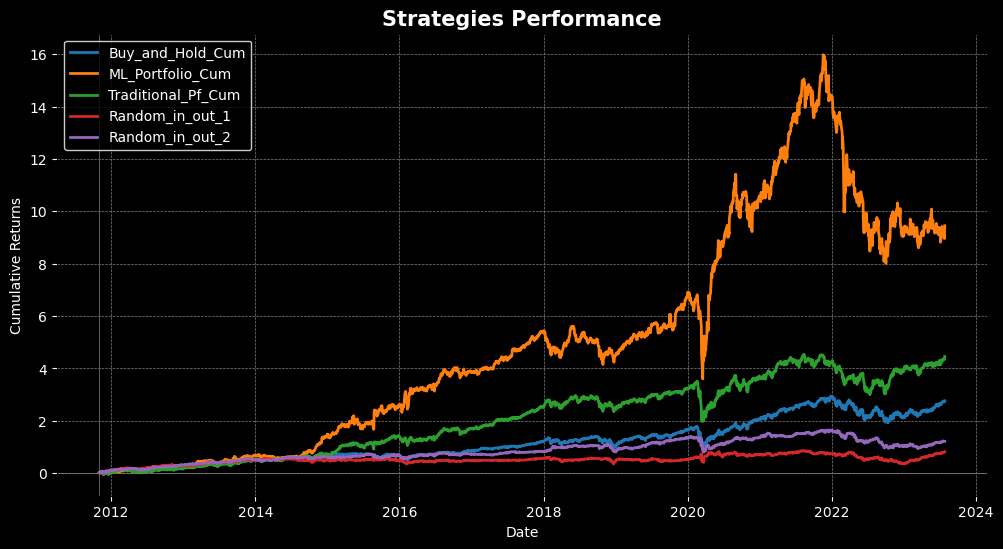

A $1 investment for the Buy & Hold strategy for holding the S&P500 would be $ 3.76 .
A $1 investment in S&P500 Random Trading strategy would be max $ 2.2199999999999998 .
A $1 investment in the Traditional Portfolio would be $ 5.45 .
A $1 investment in the Unsupervised Clustering Portfolio would be $ 10.45 .


In [40]:
fig, ax = plt.subplots(figsize=(12, 6),facecolor='black')
ax.set_facecolor('black')
ax.plot(Strategies.iloc[:,3:], linewidth=2)
ax.set_title('Strategies Performance', color='white', fontsize=15, fontweight='bold')
ax.set_xlabel('Date', color='white')
ax.set_ylabel('Cumulative Returns', color='white')
ax.legend(Strategies.columns[3:], loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
ax.grid(color='gray', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', colors='white')
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(Strategies.index[0], color='gray', linewidth=0.5)
ax.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
fig.savefig('Strategies-Performance.png')
plt.show()

print('A $1 investment for the Buy & Hold strategy for holding the S&P500 would be $', \
      round(Strategies['Buy_and_Hold_Cum'].iloc[-1]+ 1, 2),'.')
print('A $1 investment in S&P500 Random Trading strategy would be max $', \
      round(Strategies.iloc[-1][6:].max(), 2)+ 1,'.')
print('A $1 investment in the Traditional Portfolio would be $', \
      round(Strategies['Traditional_Pf_Cum'].iloc[-1]+ 1, 2),'.')
print('A $1 investment in the Unsupervised Clustering Portfolio would be $', \
      round(Strategies['ML_Portfolio_Cum'].iloc[-1] + 1, 2),'.')

In [41]:
log_returns = Strategies.iloc[:, :3]

# Function to calculate annual metrics using log returns
def calculate_metrics(log_returns):
    annual_return = log_returns.mean() * 252  # Assuming 252 trading days
    annual_volatility = log_returns.std() * np.sqrt(252)
    sharpe_ratio = (annual_return - 0.02) / annual_volatility # risk-free rate
    # cumulative_returns = np.exp(log_returns.cumsum()) - 1
    # max_drawdown = max((cumulative_returns.cummax() - cumulative_returns) / (1 + cumulative_returns.cummax()))
    
    # Calculate cumulative log returns
    cumulative_log_returns = log_returns.cumsum()
    
    # Calculate running maximum of cumulative log returns
    running_max = cumulative_log_returns.cummax()
    
    # Calculate drawdowns
    drawdowns = 1 - np.exp(cumulative_log_returns - running_max)
    
    # Get the maximum drawdown
    max_drawdown = max(drawdowns)
    
    return {
        'Annual Return': f"{annual_return * 100:.2f}%",  # Convert log return to percentage
        'Annual Volatility': f"{annual_volatility * 100:.2f}%",
        'Max Drawdown': f"{max_drawdown * 100:.2f}%",  # Convert max drawdown to percentage
        'Sharpe Ratio': f"{sharpe_ratio:.2f}"
        
    }

# Calculate metrics for each strategy
ml_metrics = calculate_metrics(log_returns.iloc[:, 0])
trad_metrics = calculate_metrics(log_returns.iloc[:, 1])
sp500_metrics = calculate_metrics(log_returns.iloc[:, 2])

# Create a dataframe with all metrics
metrics = pd.DataFrame({
    'ML Portfolio': ml_metrics,
    'Traditional Portfolio': trad_metrics,
    'S&P 500': sp500_metrics
})

# Display the results
print(metrics)

                  ML Portfolio Traditional Portfolio S&P 500
Annual Return           19.49%                14.09%  11.31%
Annual Volatility       24.02%                17.68%  17.24%
Max Drawdown            46.91%                33.97%  33.92%
Sharpe Ratio              0.73                  0.68    0.54


In [42]:
investment_universe = stock_data.loc[stock_data.index.get_level_values('Date')[0]].index.tolist()
company_names=[]
sectors = []
countries = []
market_caps = []

for t in investment_universe:
    ticker = yf.Ticker(t).get_info()
    company_names.append(ticker['longName'].replace(", Inc.", "").replace(" Inc.", "")) #.replace(" ", "_")
    sectors.append(ticker['sector'])
    countries.append(ticker['country'])
    market_caps.append(ticker['marketCap'])

stocks_info = pd.DataFrame({
    'Company_Name': company_names,
    'Sector': sectors,
    'Country': countries,
    'Market_Cap': market_caps
}, index=investment_universe)

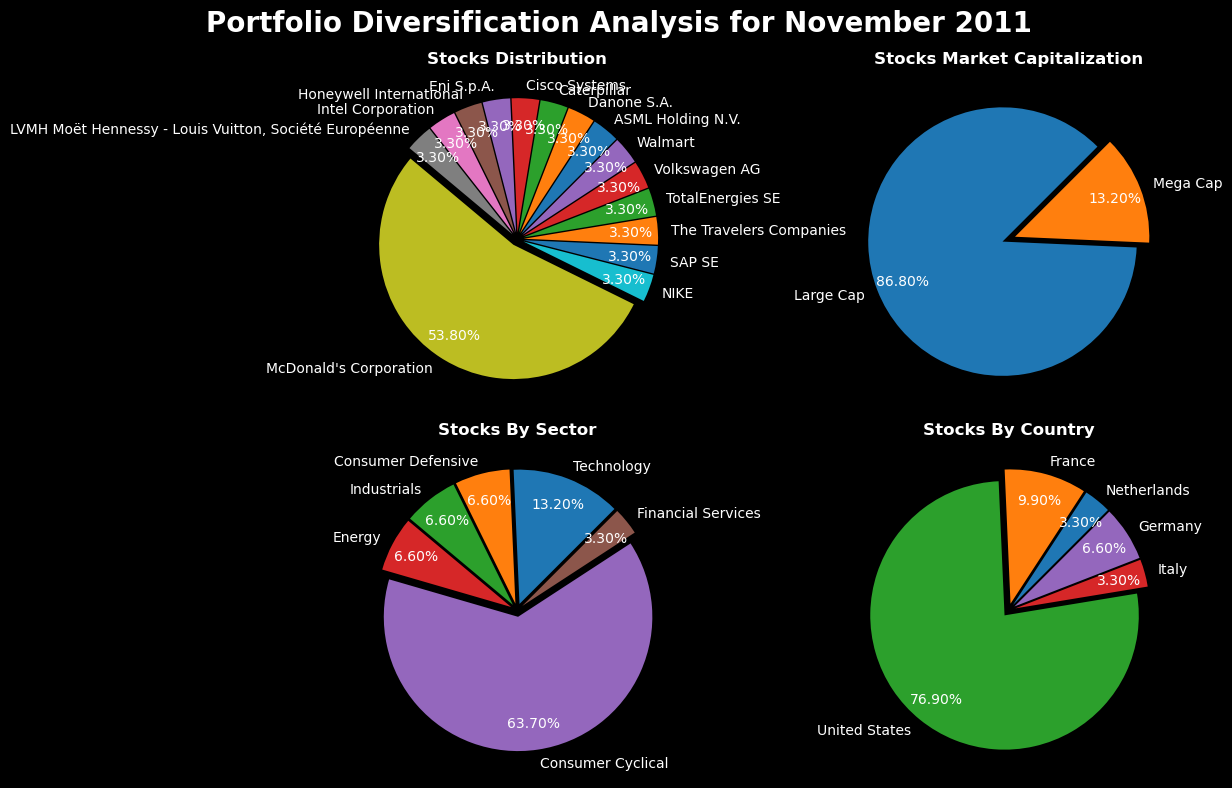

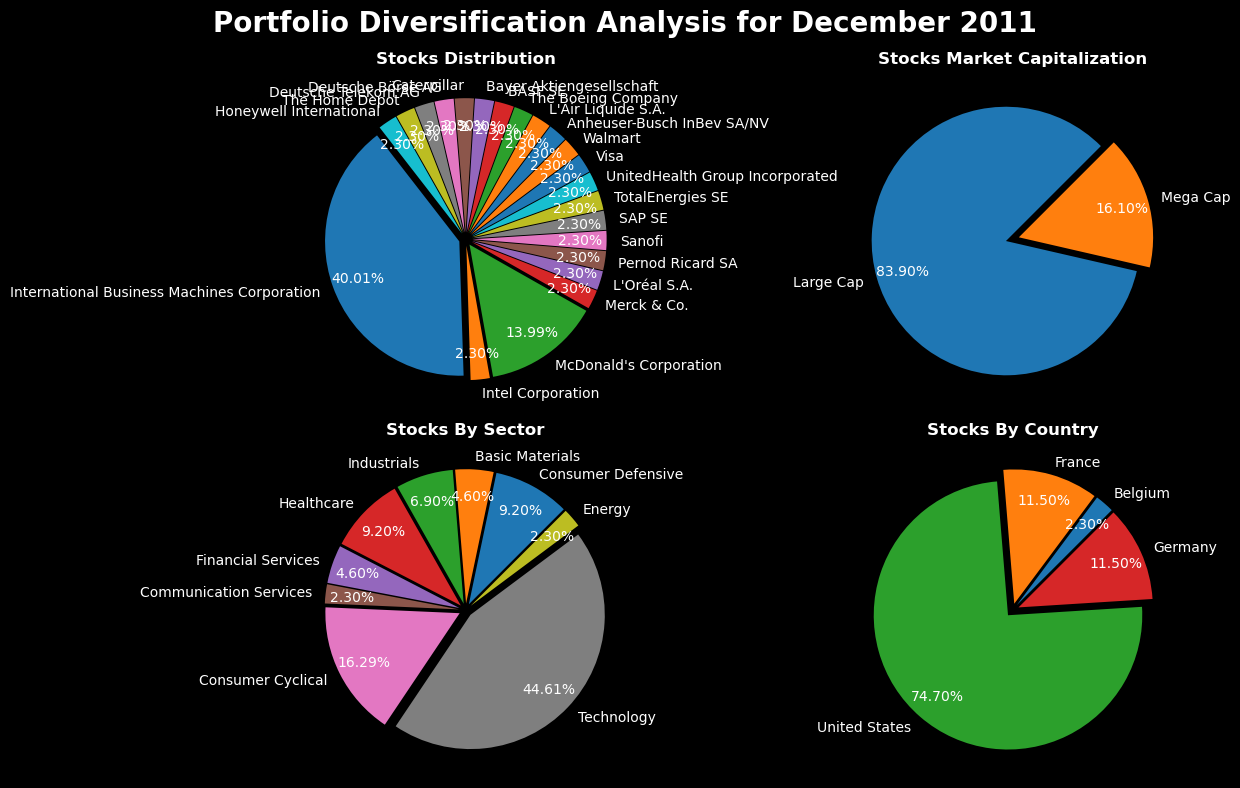

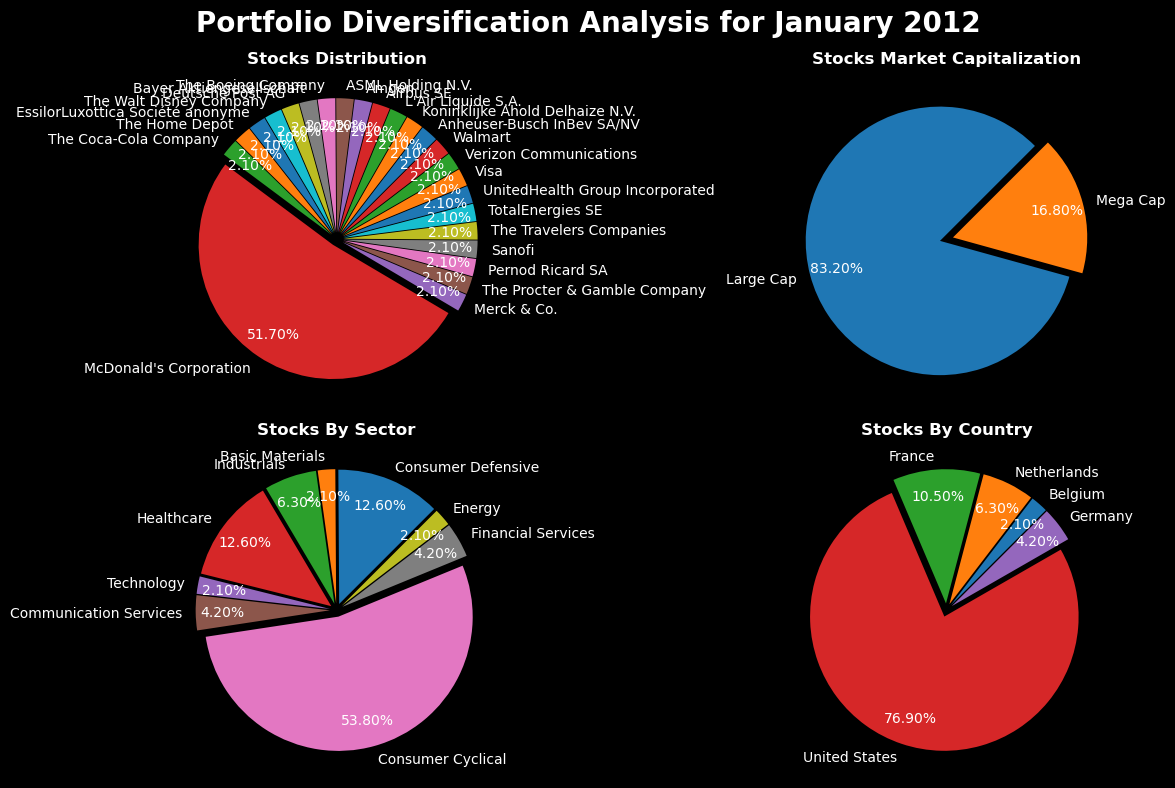

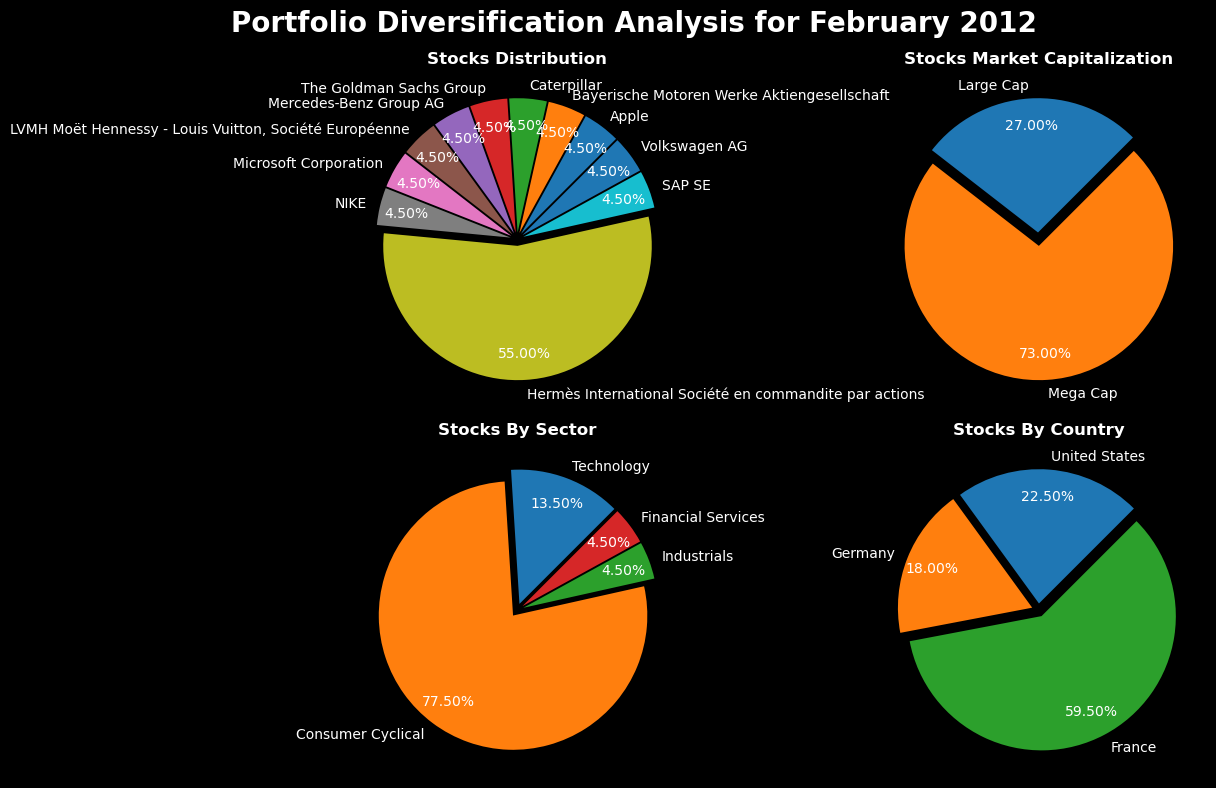

In [43]:
for date in portfolios.index.get_level_values('Date').unique().tolist()[:4]:
    
    g = portfolios.xs(date, level=0)
    stocks_list = g.index.tolist()
    stock_info = stocks_info.loc[stocks_list]

    sector_dist = {}
    for i in range(len(g)):
        sector = stock_info['Sector'].iloc[i]
        if sector not in sector_dist.keys():
            sector_dist[sector] = 0
        sector_dist[sector] += g['Weights'].iloc[i]
            
    country_dist = {}
    for i in range(len(g)):
        country = stock_info['Country'].iloc[i]
        if country not in country_dist.keys():
            country_dist[country] = 0
        country_dist[country] += g['Weights'].iloc[i]
    
    market_cap_dist = {'Nano Cap': 0.0, 'Micro Cap': 0.0, 'Mid Cap': 0.0, 'Large Cap': 0.0, 'Mega Cap': 0.0}
    for i in range(len(g)):
        market_cap = stock_info['Market_Cap'].iloc[i]
        if market_cap < 5e7:
            market_cap_dist['Nano Cap'] += g['Weights'].iloc[i]
        elif market_cap < 2.5e8:
            market_cap_dist['Micro Cap'] += g['Weights'].iloc[i]
        elif market_cap < 1e10:
            market_cap_dist['Mid Cap'] += g['Weights'].iloc[i]
        elif market_cap < 2e11:
            market_cap_dist['Large Cap'] += g['Weights'].iloc[i]
        else:
            market_cap_dist['Mega Cap'] += g['Weights'].iloc[i]
    # Create a new dictionary with only the non-zero keys
    non_zero_keys = [k for k, v in market_cap_dist.items() if v != 0.0]
    non_zero_values = [market_cap_dist[k] for k in non_zero_keys]

    # Get the month and year from the date
    month = pd.to_datetime(date).month
    year = pd.to_datetime(date).year
    
    # Get the month name
    month_name = pd.Timestamp(f"{year}-{month:02d}-01").strftime('%B')

    fig, axs = plt.subplots(2, 2, figsize=(12, 8), facecolor='black')
    fig.suptitle(f"Portfolio Diversification Analysis for {month_name} {year}", fontsize=20, color='white', fontweight='bold')
    
    # Set fixed dimensions for subplots
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    
    # Function to make labels white
    def make_autopct(values):
        def my_autopct(pct):
            return f'{pct:.2f}%' if pct > 0 else ''
        return my_autopct
    
    # First subplot: Stocks Distribution
    explode_assets = [0.05 for i in range(len(g))]
    axs[0, 0].pie(g['Weights'], labels=stock_info['Company_Name'], autopct=make_autopct(g['Weights']), # stock_info.index 
                  pctdistance=0.8, startangle=45, explode=explode_assets, colors=mcolors.TABLEAU_COLORS,
                  textprops={'color': 'white'})
    axs[0, 0].set_title("Stocks Distribution", color='white', fontweight='bold')
    
    # Second subplot: Stocks by Market Capitalization
    explode_marketcap = [0.05 for i in range(len(non_zero_values))]
    axs[0, 1].pie(non_zero_values, labels=non_zero_keys, autopct=make_autopct(non_zero_values),
                  pctdistance=0.8, startangle=45, explode=explode_marketcap, colors=mcolors.TABLEAU_COLORS,
                  textprops={'color': 'white'})
    axs[0, 1].set_title("Stocks Market Capitalization", color='white', fontweight='bold')
    
    # Third subplot: Stocks By Industry
    explode_sectors = [0.05 for i in range(len(sector_dist))]
    axs[1, 0].pie(list(sector_dist.values()), labels=sector_dist.keys(), autopct=make_autopct(list(sector_dist.values())),
                  pctdistance=0.8, startangle=45, explode=explode_sectors, colors=mcolors.TABLEAU_COLORS,
                  textprops={'color': 'white'})
    axs[1, 0].set_title("Stocks By Sector", color='white', fontweight='bold')
    
    # Fourth subplot: Stocks By Country
    explode_countries = [0.05 for i in range(len(country_dist))]
    axs[1, 1].pie(list(country_dist.values()), labels=country_dist.keys(), autopct=make_autopct(list(country_dist.values())),
                  pctdistance=0.8, startangle=45, explode=explode_countries, colors=mcolors.TABLEAU_COLORS,
                  textprops={'color': 'white'})
    axs[1, 1].set_title("Stocks By Country", color='white', fontweight='bold')
    
    plt.tight_layout()
    fig.savefig(f'PF-{month_name}-{year}.png')
    plt.show()